In [8]:
import pandas as pd
import numpy as np

# Get data

In [9]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# %%
europe_or_nearby = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark',
       'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
       'Ireland', 'Luxembourg', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Slovakia', 'Spain', 'Switzerland']

# %%
distance = pd.read_csv('data/controls/distance.csv', index_col=0)
subsidies = pd.read_csv('data/controls/energy_subsidies.csv', index_col=0)
urss = pd.read_csv('data/controls/ex_urss_influenced.csv', index_col=0)
gdppc = pd.read_csv('data/controls/GDPperCap.csv', index_col=0)
unemployment = pd.read_csv('data/controls/unemployment.csv', index_col=0)

# %%
# keep change in subsidies from 2021 to 2022
subsidies['increase'] = subsidies['2022'] - subsidies['2021']
subsidies = subsidies[['increase']].rename(columns={'increase': 'energy_subsidies_increase'})

# %%
# will talke 2022 (not the change), to account for country economic disparities

# keep only countries in Europe or nearby for gdppc
gdppc = gdppc.loc[gdppc.index.isin(europe_or_nearby)]
gdppc = gdppc[['2022']].rename(columns={'2022': 'gdppc'})

# %%
unemployment = unemployment.loc[unemployment.index.isin(europe_or_nearby)]
unemployment['increase'] = unemployment['2022'] - unemployment['2021']
unemployment = unemployment[['2022']].rename(columns={'2022': 'unemployment_increase'})

# %%
bartik = pd.read_csv('data/FINAL_BARTIK.csv', index_col=0)

# %%
approvals = pd.read_csv('../Design/data/Approvals_cleaned.csv')
approvals.drop(columns=['Sweden', 'Italy'], inplace=True)

def compute_approval_change(approvals, start_date, end_date):
    df = approvals
    df['Date'] = pd.to_datetime(df['Date'])  # ensure datetime format

    # Convert wide to long format
    df_long = df.melt(id_vars='Date', var_name='country', value_name='approval')

    # Filter date range
    df_long = df_long[(df_long['Date'] >= start_date) & (df_long['Date'] <= end_date)]

    # Calculate change from start to end per country
    start_approvals = df_long[df_long['Date'] == pd.to_datetime(start_date)]
    end_approvals = df_long[df_long['Date'] == pd.to_datetime(end_date)]

    merged = pd.merge(start_approvals, end_approvals, on='country', suffixes=('_start', '_end'))
    merged['approval_change'] = merged['approval_end'] - merged['approval_start']

    return merged[['country', 'approval_change']]

approval_change = compute_approval_change(approvals, '2022-06-01', '2022-12-01').dropna()

# %%
approval_change.index = approval_change['country']
approval_change = approval_change[['approval_change']]

# %% [markdown]
# ### Merge all together

# %%
# merge all controls into one DataFrame
dataset = distance.join(subsidies).join(gdppc).join(unemployment).join(bartik).join(approval_change) # . join(urss)

# %%
dataset.dropna(inplace=True)

# %%
# normalize the controls exept for the approval change and ex_urss_influenced
for col in dataset.columns:
    if col not in ['approval_change']:
        dataset[col] = (dataset[col] - dataset[col].mean()) / dataset[col].std()

dataset


,distance_to_kyiv_km,energy_subsidies_increase,gdppc,unemployment_increase,bartik_iv,approval_change
country,,,,,,
Austria,-0.680828,-0.306593,0.141614,-0.182295,-0.422813,-3.0
Belgium,0.464231,-0.649561,0.100734,0.031529,-0.103238,-5.0
Bulgaria,-0.730695,1.293925,-1.008635,-0.450129,0.600250,-8.0
Croatia,-0.477275,0.036375,-0.864694,0.545740,-0.144016,1.0
Czechia,-0.551055,-0.763883,-0.571669,-1.206279,1.281493,-6.0
Denmark,-0.279700,-0.649561,0.616689,-0.388719,-0.858533,-3.0
Estonia,-0.667559,-0.192270,-0.566626,0.031899,1.413947,-2.0
Finland,-0.562429,-0.649561,0.089727,0.456586,-0.703323,0.0
France,0.738211,0.379343,-0.189553,0.674478,-0.931966,-6.0


In [10]:
# megre the dataset with the media tone shift data
media = pd.read_csv('../Sentiment/Media_tone_shift.csv')
media.index = media['country']

dataset = dataset.join(media[['media_shift']])

# Test for exclusion restriction

In [11]:
import statsmodels.api as sm
from scipy.stats import pearsonr

# -------------------------------------------------
# 1.  Regress the Bartik instrument on the controls
# -------------------------------------------------
controls = [
    'distance_to_kyiv_km',      # proximity proxy
    'gdppc',                    # GDP per capita
    'energy_subsidies_increase',
    # add other controls you want to partial-out here
]

X = dataset[controls]
X = sm.add_constant(X)          # adds an intercept
y = dataset['bartik_iv']        # the instrument

first_stage = sm.OLS(y, X).fit(cov_type='HC1')
print(first_stage.summary())    # optional: inspect coefficients

# -------------------------------------------------
# 2.  Save the residuals  z̃ₗ  (Bartik purge of controls)
# -------------------------------------------------
dataset['bartik_resid'] = first_stage.resid

# -------------------------------------------------
# 3.  Correlate  z̃ₗ  with GDPpc and Proximity
# -------------------------------------------------
# (a) Pearson correlations
corr_gdppc,  pval_gdppc  = pearsonr(dataset['bartik_resid'], dataset['gdppc'])
corr_prox,   pval_prox   = pearsonr(dataset['bartik_resid'], dataset['distance_to_kyiv_km'])

print(f"Corr(resid, GDPpc)      = {corr_gdppc:.3f}  (p = {pval_gdppc:.3f})")
print(f"Corr(resid, Proximity)  = {corr_prox:.3f}   (p = {pval_prox:.3f})")

                            OLS Regression Results                            
Dep. Variable:              bartik_iv   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     2.409
Date:                Wed, 09 Jul 2025   Prob (F-statistic):              0.101
Time:                        10:26:21   Log-Likelihood:                -24.982
No. Observations:                  22   AIC:                             57.96
Df Residuals:                      18   BIC:                             62.33
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [12]:
import statsmodels.api as sm

# --------------------------------------------------
# 1.  Bivariate check:   approval_change ~ GDPpc
# --------------------------------------------------
X1 = sm.add_constant(dataset['gdppc'])      # just GDP pc and an intercept
y  = dataset['approval_change']

biv = sm.OLS(y, X1).fit(cov_type='HC1')     # HC1 = robust SEs
print("=== Bivariate regression ===")
print(biv.summary())

# --------------------------------------------------
# 2.  Multivariate check:  approval_change ~ GDPpc + other controls
# --------------------------------------------------
controls = [
    'distance_to_kyiv_km',
    'energy_subsidies_increase',

]
X2 = sm.add_constant(dataset[['gdppc'] + controls])

multi = sm.OLS(y, X2).fit(cov_type='HC1')
print("\n=== Multivariate regression ===")
print(multi.summary())

# --------------------------------------------------
# 3.  Easy-to-read takeaway
# --------------------------------------------------
coef  = multi.params['gdppc']
pval  = multi.pvalues['gdppc']
effect = "does NOT" if pval > 0.10 else "does"

print(f"\nPlain-English check: GDP per capita {effect} meaningfully predict "
      f"approval changes (coef = {coef:.3f}, p = {pval:.3f}).")


=== Bivariate regression ===
                            OLS Regression Results                            
Dep. Variable:        approval_change   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                     1.340
Date:                Wed, 09 Jul 2025   Prob (F-statistic):              0.261
Time:                        10:26:22   Log-Likelihood:                -60.757
No. Observations:                  22   AIC:                             125.5
Df Residuals:                      20   BIC:                             127.7
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5909  

In [13]:
# regress media shift on the controls
X3 = sm.add_constant(pd.concat([dataset[controls], dataset['gdppc']], axis=1))
y = dataset['media_shift']

# Drop rows with NaNs in X3 or y
mask = X3.notnull().all(axis=1) & y.notnull()
X3_clean = X3.loc[mask]
y_clean = y.loc[mask]

media_shift_reg = sm.OLS(y_clean, X3_clean).fit(cov_type='HC1')
print("\n=== Media shift regression ===")
print(media_shift_reg.summary())


=== Media shift regression ===
                            OLS Regression Results                            
Dep. Variable:            media_shift   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                 -0.096
Method:                 Least Squares   F-statistic:                     1.899
Date:                Wed, 09 Jul 2025   Prob (F-statistic):              0.173
Time:                        10:26:22   Log-Likelihood:                -10.250
No. Observations:                  19   AIC:                             28.50
Df Residuals:                      15   BIC:                             32.28
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

/home/jeanluca/.pyenv/versions/lewagon/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


Add GDP pc in first stage and check if it is still significant

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load inflation data
wb = pd.read_csv('../Design/data/world_inflation.csv', skiprows=4)

# Load GDP per capita (already normalized in your previous dataset)
gdppc = pd.read_csv('data/controls/GDPperCap.csv', index_col=0)
gdppc = gdppc[['2022']].rename(columns={'2022': 'gdppc'})

# Merge GDP with Bartik
bartik = bartik.reset_index().merge(gdppc, left_on='country', right_index=True, how='left')

# Function with GDP_pc control
def compute_inflation_shift_with_gdp(year1, year2, color, label, y_offset):
    wb_diff = wb[['Country Name', year1, year2]].rename(
        columns={year1: f'inflation_{year1}', year2: f'inflation_{year2}'}
    )
    wb_diff = wb_diff.dropna()
    wb_diff[f'inflation_{year1}'] = pd.to_numeric(wb_diff[f'inflation_{year1}'], errors='coerce')
    wb_diff[f'inflation_{year2}'] = pd.to_numeric(wb_diff[f'inflation_{year2}'], errors='coerce')
    wb_diff['inflation_change'] = wb_diff[f'inflation_{year2}'] - wb_diff[f'inflation_{year1}']

    merged = bartik.merge(wb_diff[['Country Name', 'inflation_change']],
                          left_on='country', right_on='Country Name', how='left')
    merged = merged[merged['country'].isin(europe_or_nearby)]
    merged = merged.dropna(subset=['inflation_change'])
    merged = merged[merged['inflation_change'].abs() <= 30]

    x = merged['bartik_iv'].values
    y = merged['inflation_change'].values
    gdp = merged['gdppc'].values
    names = merged['country'].values

    # OLS with GDP control
    X_ols = sm.add_constant(np.column_stack([x, gdp]))
    model = sm.OLS(y, X_ols).fit(cov_type='HC1')
    y_pred = model.predict(X_ols)

    return model, names

# 2022 in blue (current first-stage)
model_2022, names_2022 = compute_inflation_shift_with_gdp('2021', '2022', 'blue', '2022 shift', y_offset=0.6)

# 2021 in red (placebo first-stage)
model_2021, names_2021 = compute_inflation_shift_with_gdp('2020', '2021', 'red', '2021 shift', y_offset=0.2)


# Print first-stage F for Bartik conditional on GDP_pc
print(f"2022 first-stage F (conditional on GDP): {model_2022.tvalues[1]**2:.2f}")
print(f"2021 placebo-stage F (conditional on GDP): {model_2021.tvalues[1]**2:.2f}")


2022 first-stage F (conditional on GDP): 12.68
2021 placebo-stage F (conditional on GDP): 0.60


## Reg 2021 approval on Bartik

In [36]:
approvals_21 = pd.read_csv('../Design/data/Approval_2021.csv', delimiter=';', index_col=0)

In [37]:
def compute_approval_change(df):
    """
    Compute change in approval from June to December for each country.

    Args:
        df (pd.DataFrame): DataFrame with monthly approval ratings (rows: dates, cols: countries and 'Date').

    Returns:
        pd.Series: Approval change (Dec - Jun) per country.
    """
    # Convert index to datetime if needed
    df = df.copy()
    df.index = pd.to_datetime(df.index, dayfirst=True)

    # Get rows corresponding to June and December
    june = df[df.index.month == 6].iloc[0]
    dec = df[df.index.month == 12].iloc[0]

    # Drop the 'Date' column if present
    if 'Date' in df.columns:
        june = june.drop('Date')
        dec = dec.drop('Date')

    # Compute change: December - June
    return dec - june

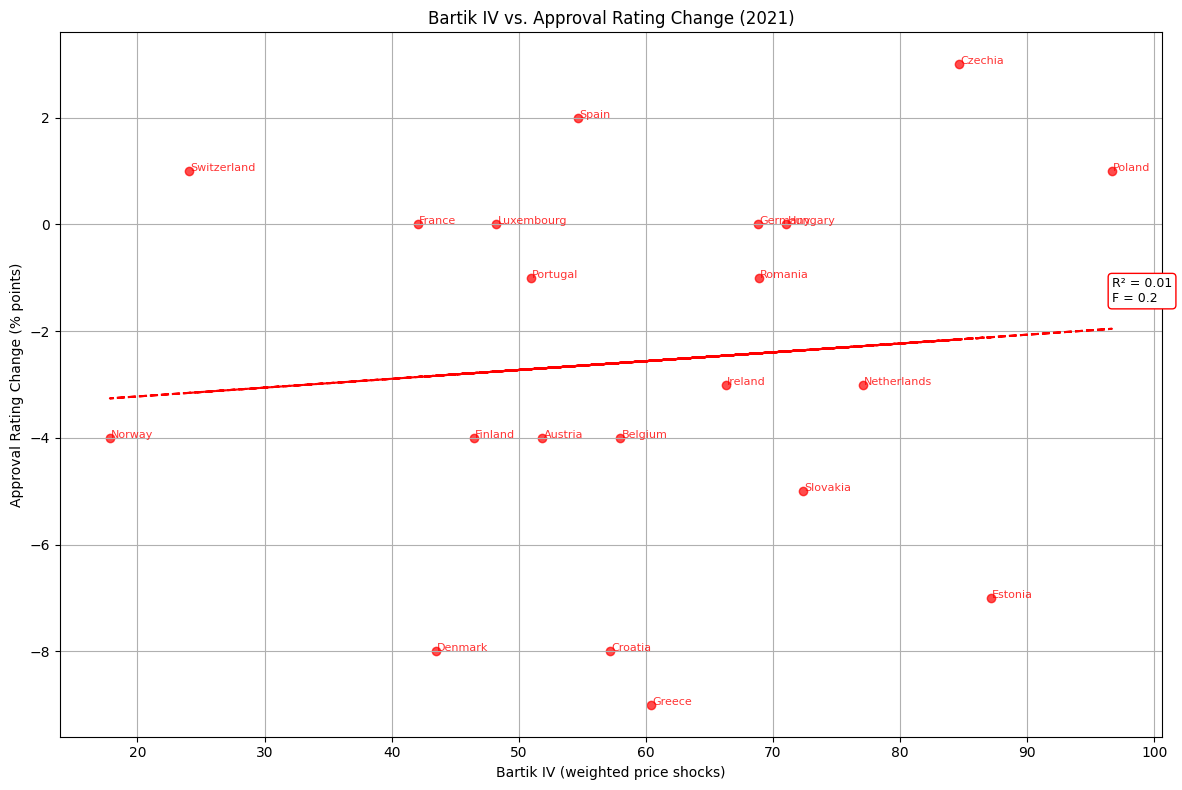

In [41]:
approval_change_21 = compute_approval_change(approvals_21).dropna()
approval_change_df = approval_change_21.reset_index()
approval_change_df.columns = ['country', 'approval_change']

# Merge with Bartik data
merged = bartik.merge(approval_change_df, on='country', how='left')
merged = merged[merged['country'].isin(europe_or_nearby)]
merged = merged.dropna(subset=['approval_change'])

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(merged['bartik_iv'], merged['approval_change'], alpha=0.7, color='red')

# Add labels
for _, row in merged.iterrows():
    plt.text(row['bartik_iv'] + 0.1, row['approval_change'], row['country'], fontsize=8, alpha=0.8, color='red')

# Regression
X = sm.add_constant(merged['bartik_iv'])
model = sm.OLS(merged['approval_change'], X).fit()
y_pred = model.predict(X)

# Plot regression line
plt.plot(merged['bartik_iv'], y_pred, linestyle='--', linewidth=1.5, color='red', label='OLS fit')

# R² and F-stat
r2 = model.rsquared
fstat = model.fvalue
textstr = f'R² = {r2:.2f}\nF = {fstat:.1f}'
plt.text(max(merged['bartik_iv']), max(y_pred) + 0.5, textstr,
         fontsize=9, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

# Labels
plt.title("Bartik IV vs. Approval Rating Change (2021)")
plt.xlabel("Bartik IV (weighted price shocks)")
plt.ylabel("Approval Rating Change (% points)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        approval_change   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.1641
Date:                Wed, 09 Jul 2025   Prob (F-statistic):              0.690
Time:                        10:44:54   Log-Likelihood:                -55.423
No. Observations:                  21   AIC:                             114.8
Df Residuals:                      19   BIC:                             116.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5543      2.547     -1.395      0.1